In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from scipy.signal import butter, filtfilt, freqz
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
import pickle

/home/users/ilanazs/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [2]:
fly_num = 'fly_183'
func_path = f'/oak/stanford/groups/trc/data/Ilana/2P/data/{fly_num}/func_0/'


In [3]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')

### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)

# *100 puts in units of 10ms, which will match fictrac
st_10ms = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times))]

# get 1ms version to match neural timestamps
st_ms= [i*10 for i in st_10ms]

loading photodiode data... done


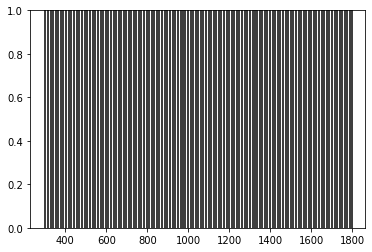

In [4]:
for i in stimulus_start_times:
    plt.axvline(i,color='k')


In [ ]:
#not sure i have this info yet??????

stim_time = 1 #need to get meta data from visprotocol file to figure out itis/stim times
post_time = 1.25
# How long should a cluster of epochs be?
epoch_cluster_duration = 6.25 #in min # THIS IS SET BASED ON 5 1MIN GREY PERIODS AND 4 STIM PERIODS FOR 30MIN TOTAL
epoch_cluster_duration *= 60 # now in sec

###############################################
### CREATE LONG LIST OF ALL STIM TO PRESENT ###
###############################################

epoch_duration = post_time + stim_time
# given the duration of a single epoch and a cluster of epochs, how many epochs to present?
num_epochs_in_cluster = int(epoch_cluster_duration / epoch_duration)
num_single_stim_type = int(num_epochs_in_cluster/4)

In [5]:
####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ', 'dRotLabX']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    elif behavior == 'dRotLabX': short = 'X'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
fictrac_timestamps = np.arange(0,expt_len,resolution)

In [6]:
fictrac_raw.keys()

Index(['frameCounter',     'dRotCamX',     'dRotCamY',     'dRotCamZ',
          'dRotScore',     'dRotLabX',     'dRotLabY',     'dRotLabZ',
         'AbsRotCamX',   'AbsRotCamY',   'AbsRotCamZ',   'AbsRotLabX',
         'AbsRotLabY',   'AbsRotLabZ',    'positionX',    'positionY',
            'heading',   'runningDir',        'speed',  'integratedX',
        'integratedY',    'timeStamp',     'sequence',             23,
                   24],
      dtype='object')

In [7]:
def extract_traces(fictrac, stim_times, pre_window, post_window, val):
    traces = []
    for i in range(len(stim_times)):
        trace = fictrac[val][stim_times[i]-pre_window:stim_times[i]+post_window]
        if len(trace) == pre_window + post_window: # this handles fictrac that crashed or was aborted or some bullshit
            traces.append(trace)
    traces = np.asarray(traces)
    mean_trace = np.mean(traces,axis=0)
    sem_trace = scipy.stats.sem(traces,axis=0)
    return traces, mean_trace, sem_trace

In [8]:
starts_loom = st_10ms

In [18]:
###########################################
### Extract Stimulus Triggered Behavior ###
###########################################

pre_window = 200
post_window = 300
# avg_around = 20
# stim_time = 75

behavior_traces = {}
mean_trace = {}
sem_trace = {}
behavior_traces,mean_trace,sem_trace = extract_traces(fictrac, starts_loom, pre_window, post_window, 'Y')
# behavior_traces_x,mean_trace,sem_trace = extract_traces(fictrac, starts_loom, pre_window, post_window, 'X')
# behavior_traces_z,mean_trace,sem_trace = extract_traces(fictrac, starts_loom, pre_window, post_window, 'Z')


(30208.0, 42891.0)

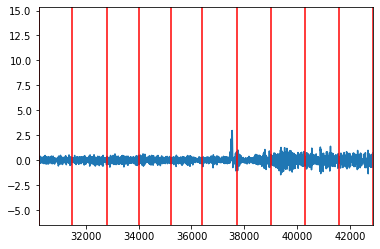

In [36]:
plt.plot(fictrac['Y'])
for i in range(len(starts_loom)):
    plt.axvline(starts_loom[i], color='r')
plt.xlim(starts_loom[0], starts_loom[10])

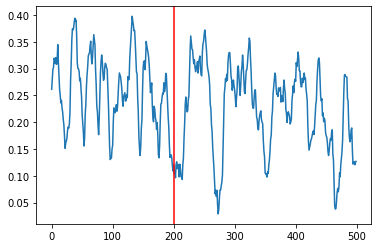

In [27]:
plt.plot(mean_trace);
plt.axvline(200,color='r')



In [37]:
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data, method="gust")
    return y

# def butter_lowpass_filter(data, cutoff, fs, order=5):
#     b, a = butter_lowpass(cutoff, fs, order=order)
#     y = lfilter(b, a, data)
#     return y

In [38]:
ts = fictrac_raw["timeStamp"] #in ms i think
ts_sec = ts/1000
fr = 1/np.mean(np.diff(ts_sec)) #figure out frame_rate from bruker fictrac

In [39]:
# 10 ms
TP_WIDTH_SECONDS = 0.01

TRIAL_TIME_SEC = 1
# time in seconds that the stimulus is presented at
STIM_TIME_SECONDS = 2
STIM_END_SECONDS = STIM_TIME_SECONDS + TRIAL_TIME_SEC
# time in seconds between end of pre trial window and the stimulus time. 
# when set to zero, the pre trial window ends when the stimulus is presented
PRE_TRIAL_WINDOW_STIM_SEP_SECONDS = -0.05
# size of window that pre trial speed is averaged over, seconds, window ends at stimulus time
PRE_TRIAL_WINDOW_SECONDS = 0
# size of post trial speed average window, seconds, 
POST_TRIAL_WINDOW_SECONDS = 0.5
# post trial window starts at stim time + post trial delay 
POST_TRIAL_DELAY_SECONDS = 0

STIM_IDX = int(STIM_TIME_SECONDS / TP_WIDTH_SECONDS)
STIM_END_IDX = int(STIM_END_SECONDS / TP_WIDTH_SECONDS)
TRIAL_END_IDX = int(TRIAL_TIME_SEC/ TP_WIDTH_SECONDS + STIM_IDX)
SEP_IDX = PRE_TRIAL_WINDOW_STIM_SEP_SECONDS / TP_WIDTH_SECONDS

PRE_TRIAL_END_IDX = int(STIM_IDX - SEP_IDX)
PRE_TRIAL_START_IDX = int(PRE_TRIAL_END_IDX - PRE_TRIAL_WINDOW_SECONDS / TP_WIDTH_SECONDS)

POST_TRIAL_START_IDX = int(STIM_IDX + POST_TRIAL_DELAY_SECONDS / TP_WIDTH_SECONDS)
POST_TRIAL_END_IDX = int(POST_TRIAL_START_IDX + POST_TRIAL_WINDOW_SECONDS / TP_WIDTH_SECONDS)

SPEED_THRESHOLD = 0

In [40]:
# Filter requirements.
order = 4
fs = fr      # sample rate, Hz
cutoff = 3  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, fs=fs, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(w, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
# plt.grid()

# Filter the data, and plot both the original and filtered signals.
lpf_behavior = np.zeros((behavior_traces.shape[0], behavior_traces.shape[1] - STIM_IDX))
print(lpf_behavior.shape)

for i in range(behavior_traces.shape[0]):
    lpf_behavior[i, :] = butter_lowpass_filter(behavior_traces[i,STIM_IDX:], cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(np.mean(behavior_traces[:, STIM_IDX:], axis=0), 'b-', label='data')
plt.plot(np.mean(lpf_behavior, axis=0), 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time')
# plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

ValueError: Digital filter critical frequencies must be 0 < Wn < fs/2 (fs=0.00010000034070862004 -> fs/2=5.000017035431002e-05)

In [ ]:
# (n_trials,)
if PRE_TRIAL_START_IDX!=PRE_TRIAL_END_IDX:
    pre_trial_speed = np.mean(behavior_traces[:, PRE_TRIAL_START_IDX:PRE_TRIAL_END_IDX], axis=1)
else:
    pre_trial_speed = np.asarray(behavior_traces[:, PRE_TRIAL_START_IDX])
# (n_trials,)
if POST_TRIAL_START_IDX!=POST_TRIAL_END_IDX:
    post_trial_speed = np.mean(behavior_traces[:, POST_TRIAL_START_IDX:POST_TRIAL_END_IDX], axis=1)
else:
    post_trial_speed = np.asarray(behavior_traces[:, POST_TRIAL_START_IDX])


In [ ]:
# behavior with the low pass filter (n_trials,)
pre_tsi= PRE_TRIAL_START_IDX-STIM_IDX
pre_tei = PRE_TRIAL_END_IDX-STIM_IDX
post_tsi = POST_TRIAL_START_IDX-STIM_IDX
post_tei = POST_TRIAL_END_IDX-STIM_IDX

if PRE_TRIAL_START_IDX!=PRE_TRIAL_END_IDX:
    pre_trial_speed = np.mean(lpf_behavior[:, pre_tsi:pre_tei], axis=1)
else:
    pre_trial_speed = np.asarray(lpf_behavior[:, pre_tsi])
# (n_trials,)
if POST_TRIAL_START_IDX!=POST_TRIAL_END_IDX:
    post_trial_speed = np.mean(lpf_behavior[:, post_tsi:post_tei], axis=1)
else:
    post_trial_speed = np.asarray(lpf_behavior[:, post_tsi])


In [ ]:
# (n_trials,) positive if they start slow and end fast, negative for vice versa
speed_change = post_trial_speed - pre_trial_speed

In [ ]:
# SLOW_TRIAL_SELECTION = np.logical_not(speed_change < SPEED_THRESHOLD)
# SLOW_TRIAL_IDXS = np.where(SLOW_TRIAL_SELECTION)[0]
# slow_ind = SLOW_TRIAL_IDXS

In [ ]:
# fig, ax = plt.subplots()

# ax.hist(speed_change, bins = 50)

In [ ]:
thresh = 0.05

print(np.sum(speed_change <-thresh))
print(np.sum(np.logical_and(speed_change>-thresh, speed_change<thresh)))
print(np.sum(speed_change>thresh))

decrease_trials = speed_change <-thresh
decrease_idx = np.where(decrease_trials)
increase_trials = speed_change>thresh
increase_idx = np.where(increase_trials)
flat_trials = np.logical_and(speed_change>-thresh, speed_change<thresh)
flat_idx = np.where(flat_trials)

# OLD

##Find the indicies of trials where the speed decreased past a certain threshold (presumed freezing)
diffs = behavior_traces[:,pre_window] - behavior_traces[:,(pre_window+avg_around)]
plt.plot(diffs)
print(np.size(diffs))
threshold = 0.001
slow_ind = np.where(diffs>threshold)[0]
for idx in slow_ind:
    plt.axvline(idx,color='r',linestyle='--',lw=1)

In [ ]:
def validate_trial(trial_idx, trace=None):
    """ Visualize a single trial, along with the pre and post averaging windows
    
    RED: pre window
    YELLOW: post window
    BLUE: stim time
    """
    if trace is None:
        trace = behavior_traces[trial_idx]
    plt.plot(trace)
    plt.axvline(PRE_TRIAL_START_IDX, color='r')
    plt.axvline(PRE_TRIAL_END_IDX, color='r')
    plt.axvline(POST_TRIAL_START_IDX, color='y')
    plt.axvline(POST_TRIAL_END_IDX, color='y')
    plt.axvline(STIM_IDX, color='b')


def validate_windows(behavior_traces):
    """ Visualize average traces for both slow and fast trials
    
    NOTE: uses global variables, must rerun constant cells and slow_ind logic to change results.
    
    RED: pre window
    YELLOW: post window
    BLUE: stim time
    """
    increase_traces = behavior_traces[increase_trials]
    decrease_traces = behavior_traces[decrease_trials]
    flat_traces = behavior_traces[flat_trials]
    
    print(f"{len(increase_traces)} increase trials")
    print(f"{len(decrease_traces)} decrease trials")
    print(f"{len(flat_traces)} flat trials")
    
    increase_mean = np.mean(increase_traces, axis=0)
    increase_sem = scipy.stats.sem(increase_traces, axis=0)
    
    decrease_mean = np.mean(decrease_traces, axis=0)
    decrease_sem = scipy.stats.sem(decrease_traces, axis=0)
    
    flat_mean = np.mean(flat_traces, axis=0)
    flat_sem = scipy.stats.sem(flat_traces, axis=0)
    
    fig, axes = plt.subplots(nrows=3)
    
    axes[0].plot(increase_mean, color='k',linewidth=3)
    axes[0].fill_between(np.arange(len(increase_mean)), increase_mean - increase_sem, increase_mean + increase_sem, color='k',alpha=0.3)
    axes[0].axvline(PRE_TRIAL_START_IDX, color='r')
    axes[0].axvline(PRE_TRIAL_END_IDX, color='r')
    axes[0].axvline(POST_TRIAL_START_IDX, color='y')
    axes[0].axvline(POST_TRIAL_END_IDX, color='y')
    axes[0].axvline(STIM_IDX, color='b', linestyle='--')
    axes[0].axvline(STIM_END_IDX, color='b', linestyle='--')
#     axes[0].set_title("slow trials")
    

    
    axes[1].plot(decrease_mean, color='k',linewidth=3)
    axes[1].fill_between(np.arange(len(decrease_mean)), decrease_mean - decrease_sem, decrease_mean + decrease_sem, color='k',alpha=0.3)
    axes[1].axvline(PRE_TRIAL_START_IDX, color='r')
    axes[1].axvline(PRE_TRIAL_END_IDX, color='r')
    axes[1].axvline(POST_TRIAL_START_IDX, color='y')
    axes[1].axvline(POST_TRIAL_END_IDX, color='y')
    axes[1].axvline(STIM_IDX, color='b', linestyle='--')
    axes[1].axvline(STIM_END_IDX, color='b', linestyle='--')
    
    axes[2].plot(flat_mean, color='k',linewidth=3)
    axes[2].fill_between(np.arange(len(flat_mean)), flat_mean - flat_sem, flat_mean + flat_sem, color='k',alpha=0.3)
    axes[2].axvline(PRE_TRIAL_START_IDX, color='r')
    axes[2].axvline(PRE_TRIAL_END_IDX, color='r')
    axes[2].axvline(POST_TRIAL_START_IDX, color='y')
    axes[2].axvline(POST_TRIAL_END_IDX, color='y')
    axes[2].axvline(STIM_IDX, color='b', linestyle='--')
    axes[2].axvline(STIM_END_IDX, color='b', linestyle='--')
    
    return fig, axes


In [ ]:
slow_traces = behavior_traces[SLOW_TRIAL_SELECTION]
fast_traces = behavior_traces[np.logical_not(SLOW_TRIAL_SELECTION)]

In [ ]:
slow_during_stim = slow_traces[:,STIM_IDX:TRIAL_END_IDX]
fast_during_stim = fast_traces[:,STIM_IDX:TRIAL_END_IDX]

In [ ]:
dy = np.diff(slow_during_stim)/(TRIAL_END_IDX-STIM_IDX)
mean_dy = np.mean(dy, axis=0)
mean_dy

In [ ]:
plt.plot(mean_dy)

In [ ]:
STIM_IDX

In [ ]:
fig, axes = validate_windows(behavior_traces)
# axes[0].plot(np.arange(STIM_IDX,TRIAL_END_IDX-1), mean_dy, color='g')
fig.tight_layout()

In [ ]:
# plotting all average behavior around the looming stim
plt.figure(figsize=(10,10))
plt.plot(mean_trace,color='k',linewidth=3)
plt.fill_between(np.arange(len(mean_trace)),mean_trace-sem_trace, mean_trace+sem_trace, color='k',alpha=0.3)
plt.ylim(-1, 5)
plt.axvline(STIM_IDX,color='k',linestyle='--',lw=2)
plt.axvline(STIM_END_IDX,color='k',linestyle='--',lw=2)

    

In [ ]:
#Only plotting behavior of the trials where the fly froze

decrease_traces = behavior_traces[decrease_trials]
decrease_mean = np.mean(decrease_traces, axis=0)
decrease_sem = scipy.stats.sem(decrease_traces, axis=0)

plt.figure(figsize=(10,10))
plt.plot(decrease_mean,color='k',linewidth=3)
plt.fill_between(np.arange(len(decrease_mean)),decrease_mean-decrease_sem, decrease_mean+decrease_sem, color='k',alpha=0.3)
plt.ylim(-1, 3.5)
plt.axvline(STIM_IDX,color='k',linestyle='--',lw=2)
plt.axvline(STIM_END_IDX,color='k',linestyle='--',lw=2)
np.shape(decrease_traces)

In [ ]:
#Only plotting behavior of the trials where the fly didn't freeze

increase_traces = behavior_traces[increase_trials]
increase_mean = np.mean(increase_traces, axis=0)
increase_sem = scipy.stats.sem(increase_traces, axis=0)

plt.figure(figsize=(10,10))
plt.plot(increase_mean,color='k',linewidth=3)
plt.fill_between(np.arange(len(increase_mean)),increase_mean-increase_sem, increase_mean+increase_sem, color='k',alpha=0.3)
plt.ylim(-1, 3.5)
plt.axvline(STIM_IDX,color='k',linestyle='--',lw=2)
plt.axvline(STIM_END_IDX,color='k',linestyle='--',lw=2)
np.shape(increase_traces)

In [ ]:
#Only plotting behavior of the trials where the fly didn't move much

flat_traces = behavior_traces[flat_trials]
flat_mean = np.mean(flat_traces, axis=0)
flat_sem = scipy.stats.sem(flat_traces, axis=0)

plt.figure(figsize=(10,10))
plt.plot(flat_mean,color='k',linewidth=3)
plt.fill_between(np.arange(len(flat_mean)),flat_mean-flat_sem, flat_mean+flat_sem, color='k',alpha=0.3)
plt.ylim(-1, 3.5)
plt.axvline(STIM_IDX,color='k',linestyle='--',lw=2)
plt.axvline(STIM_END_IDX,color='k',linestyle='--',lw=2)
np.shape(flat_traces)

# load neural

In [ ]:
n_clusters = 2000
cluster_dir = os.path.join(func_path, 'clustering')

load_file = os.path.join(cluster_dir, 'cluster_labels.npy')
cluster_labels = np.load(load_file)

load_file = os.path.join(cluster_dir, 'cluster_signals.npy')
all_signals = np.load(load_file)

In [ ]:
time_average =np.mean(all_signals, axis=(0,1))

# Fictrac checks

In [ ]:
fictrac['Y'] = np.squeeze(fictrac['Y'])
out = scipy.signal.correlate(time_average, fictrac['Y'])

In [ ]:
plt.plot(out)
plt.axvline(3384,color='k')
plt.xlim(3300,3400)

# check warp quality

In [ ]:
fixed = brainsss.load_fda_meanbrain()

In [ ]:
fixed

In [ ]:
atlas = brainsss.load_roi_atlas()

In [ ]:
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [ ]:
timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))

In [ ]:
fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps[:,20])
fictrac_timestamps = np.arange(0,expt_len,resolution)

In [ ]:
warp_dir = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/{fly_num}/warp/'
f2a = ants.image_read(os.path.join(warp_dir, 'func-to-anat.nii'))

In [ ]:
plt.imshow(f2a[:,:,50].T)

In [ ]:
warp_dir = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/{fly_num}/warp/'
a2a = ants.image_read(os.path.join(warp_dir, 'anat-to-meanbrain.nii'))

In [ ]:
a2a

In [ ]:
directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/{fly_num}/anat_0/moco'
anat = ants.image_read(os.path.join(directory, 'anatomy_channel_1_moc_mean.nii'))

In [ ]:
anat.set_spacing((0.653, 0.653, 1))

In [ ]:
anat_low=anat.resample_image((2,2,2),use_voxels=False)

In [ ]:
z=20
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(a2a[:,:,z].T)
plt.subplot(2,1,2)
plt.imshow(fixed[:,:,z].T)

In [ ]:
bin_start = -500; bin_end = 2000; bin_size = 100
neural_bins = np.arange(bin_start,bin_end,bin_size)

# STA wrapped

In [ ]:
starts_loom_ms = [i*10 for i in starts_loom]

In [ ]:
decrease_starts = []
for idx in decrease_idx[0]:
    decrease_starts.append(starts_loom[idx])
decrease_starts_ms = [n*10 for n in decrease_starts]
print(np.shape(decrease_starts_ms))

increase_starts = []
for idx in increase_idx[0]:
    increase_starts.append(starts_loom[idx])
increase_starts_ms = [n*10 for n in increase_starts]
print(np.shape(increase_starts_ms))

flat_starts = []
for idx in flat_idx[0]:
    flat_starts.append(starts_loom[idx])
flat_starts_ms = [n*10 for n in flat_starts]
print(np.shape(flat_starts_ms))

In [ ]:
t0 = time.time()
STA_brain_decrease = brainsss.make_STA_brain(neural_signals = all_signals,
                                   neural_timestamps = timestamps,
                                   event_times_list = decrease_starts_ms,
                                   neural_bins = neural_bins)

STA_brain_increase = brainsss.make_STA_brain(neural_signals = all_signals,
                                   neural_timestamps = timestamps,
                                   event_times_list = increase_starts_ms,
                                   neural_bins = neural_bins)

STA_brain_flat = brainsss.make_STA_brain(neural_signals = all_signals,
                                   neural_timestamps = timestamps,
                                   event_times_list = flat_starts_ms,
                                   neural_bins = neural_bins)
print(F'STA {time.time()-t0}')

In [ ]:
STA_brain_decrease = np.nan_to_num(STA_brain_decrease)
STA_brain_increase = np.nan_to_num(STA_brain_increase)
STA_brain_flat = np.nan_to_num(STA_brain_flat)

In [ ]:
reformed_STA_brain_decrease = brainsss.STA_supervoxel_to_full_res(STA_brain_decrease, cluster_labels)
reformed_STA_brain_increase = brainsss.STA_supervoxel_to_full_res(STA_brain_increase, cluster_labels)
reformed_STA_brain_flat = brainsss.STA_supervoxel_to_full_res(STA_brain_flat, cluster_labels)

In [ ]:
reformed_STA_brain = reformed_STA_brain_non_freeze-reformed_STA_brain_freeze
#to subract the different trials

In [ ]:
plt.imshow(reformed_STA_brain[25,13,:,:].T,)
# plt.imshow(reformed_STA_brain_non_freeze[25,13,:,:].T,)

In [ ]:
#change the STA brain based on condition
STA_brain = gaussian_filter1d(reformed_STA_brain_decrease,sigma=1,axis=1,truncate=1)

In [ ]:
t0 = time.time()
warps = brainsss.warp_STA_brain(STA_brain=STA_brain, fly=fly_num, fixed=fixed, anat_to_mean_type='myr')
print(F'Warps {time.time()-t0}')

In [ ]:
def extract_roi_signal_traces(roi_ids, roi_masks, warps, hemi, signal_type):
    t0 = time.time()
    roi_time_avgs = []
    for roi in roi_ids[hemi]:
        mask = roi_masks[roi]
        masked_data = warps[:,:,:,:]*mask[np.newaxis,:,:,:] #note z-flip
        if signal_type == 'max':
            roi_time_avg = np.max(masked_data,axis=(1,2,3))
        elif signal_type == 'mean':
            roi_time_avg = np.mean(masked_data,axis=(1,2,3))
        roi_time_avgs.append(roi_time_avg)
    print(time.time()-t0)
    return np.asarray(roi_time_avgs)

In [ ]:
explosions = []
t0 = time.time()
for tp in range(24):
    input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
    data_to_plot = warps[tp][:,:,::-1]
    vmax = 0.5
    explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                        roi_masks,
                                                        roi_contours,
                                                        data_to_plot,
                                                        input_canvas,
                                                        vmax=vmax,
                                                        cmap='seismic', diverging=True)#'hot')
    explosions.append(explosion_map)
print(F'Explosion {time.time()-t0}')

In [ ]:
ilana_path = f'/oak/stanford/groups/trc/data/Ilana/2P/data/{fly_num}/'
if os.path.exists(ilana_path)==False:
    os.mkdir(ilana_path)


In [ ]:
movie_dir = os.path.join(ilana_path, 'movies')
if os.path.exists(movie_dir)==False:
    os.mkdir(movie_dir)
print(movie_dir)

In [ ]:
save_dir = os.path.join(movie_dir,'decrease')
if os.path.exists(save_dir)==False:
    os.mkdir(save_dir)
print(save_dir)

In [ ]:
plt.figure(figsize=(10,10))
for i in range(24):
    print(i)
    plt.imshow(explosions[i][170:,:]) #this was made with cmap=hot
    fname = os.path.join(save_dir, '{0:05d}.png'.format(i))
    plt.savefig(fname,dpi=300,bbox_inches='tight')